# Utils

In [19]:
import os
from scipy.io import loadmat
import shutil
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
from Images.utils_neuromaps_brain import *
from nilearn import datasets, surface, plotting
import nibabel as nib
from nilearn.image import new_img_like
from matplotlib import ticker
from matplotlib import colors
import matplotlib.colors as mcolors
import pickle as pk
import re
from typing import List, Set, Tuple
from collections import Counter

In [20]:
tree_path = "/home/sun/Projects/RHOSTS/Sample_results"
sub1_input = "/home/sun/Projects/RHOSTS/Input/subject1_left.txt"
sub1_output = "/home/sun/Projects/RHOSTS/Output/subject1_left_results.txt"
sub1_output_sorted = "/home/sun/Projects/RHOSTS/Output/subject1_left_results.sorted.txt"
sub1_output_proj = '/home/sun/Projects/RHOSTS/Output/sub1_left_weighted.hd5'
sub1_scaffold = '/home/sun/Projects/RHOSTS/Output/scaffold_gen/'
sub1_scaffold2 = '/home/sun/Projects/RHOSTS/Output/scaffold2_gen/'
sub1_scaffold3 = '/home/sun/Projects/RHOSTS/Output/scaffold3_gen'
path_scaffold_folder = '/home/sun/Projects/RHOSTS/High_order_TS_with_scaffold'
generators0 = "/home/sun/Projects/RHOSTS/Output/scaffold2_gen/generators__0.pck"


In [21]:
from matplotlib import font_manager as fm, rcParams
import glob, os

# registra esplicitamente i TTF installati localmente
for path in glob.glob(os.path.expanduser("~/.local/share/fonts/PTSerif/*.ttf")):
    fm.fontManager.addfont(path)

# imposta la famiglia
rcParams["font.family"] = "PT Serif"

# verifica
print(sorted({f.name for f in fm.fontManager.ttflist if "PT Serif" in f.name}))

for path in glob.glob(os.path.expanduser("~/.local/share/fonts/PTSerifCaption/*.ttf")):
    fm.fontManager.addfont(path)

rcParams["font.family"] = "PT Serif Caption"  # se vuoi usare la Caption
print(sorted({f.name for f in fm.fontManager.ttflist if "PT Serif" in f.name}))

['PT Serif', 'PT Serif Caption']
['PT Serif', 'PT Serif Caption']


# Project Exploration

Some info about the files

In [22]:
def print_tree(start_path, prefix=''):
    for i, item in enumerate(sorted(os.listdir(start_path))):
        path = os.path.join(start_path, item)
        connector = "└── " if i == len(os.listdir(start_path)) - 1 else "├── "
        print(prefix + connector + item)
        if os.path.isdir(path):
            extension = "    " if i == len(os.listdir(start_path)) - 1 else "│   "
            print_tree(path, prefix + extension)

In [23]:
print_tree(tree_path)

├── edges_projection_T0_1200_N50.hd5
├── results_T0_1200_N50.txt
├── results_sub1_left_1200.txt.hd5
└── trial_gen
    ├── generators__0.pck
    ├── generators__1.pck
    ├── generators__2.pck
    ├── generators__3.pck
    └── generators__4.pck


# Brain

## Input Data

One subject example taken from [HCP]

- 119 rows: Representing 119 brain regions of interest (ROIs).

- 1200 columns: Representing time points or temporal samples.


In [24]:
np.loadtxt(sub1_input).shape

(1200, 119)

## Output Data

### Check and order

In [25]:
# Regex to capture the integer timepoint from filenames like "generators__123.pck"
pat = re.compile(r"^generators__([0-9]+)\.pck$")

def list_timepoints(folder):
    """Return a sorted list of integer timepoints found in a folder by matching 'generators__N.pck' files."""
    tps = []
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Folder not found: {folder}")
    for f in os.listdir(folder):
        m = pat.match(f)
        if m:
            tps.append(int(m.group(1)))
    return sorted(tps)

# -------------------------
# Read and validate the text Output file
# -------------------------
rows = []
bad  = []

with open(sub1_output, "r") as f:
    for ln, line in enumerate(f, start=1):
        s = line.strip()
        if not s:
            continue  # skip empty lines
        parts = s.split()
        try:
            # First token must be an integer timepoint
            t = int(parts[0])
            # Remaining tokens: 6 float metrics (we won't enforce exactly 6 here, just parse what is present)
            vals = list(map(float, parts[1:]))
            rows.append((t, vals, s))  # keep original string s for potential re-writing
        except Exception:
            bad.append((ln, s))

print("=== Controllo file Output ===")
print("Numero righe totali :", len(rows) + len(bad))
print("Righe valide (con time point intero):", len(rows))
print("Righe scartate:", len(bad))

# Collect timepoints from valid rows
ts = [r[0] for r in rows]

if not ts:
    raise ValueError("Nessun timepoint valido letto dal file: controlla il formato di input.")

# Sort rows by timepoint for consistency
rows_sorted = sorted(rows, key=lambda r: r[0])

# Basic integrity checks on timepoints inside the file
cnt = Counter(ts)
duplicati = sorted([t for t, c in cnt.items() if c > 1])
mancanti = sorted(set(range(min(ts), max(ts)+1)) - set(ts))

print("Time points duplicati:", duplicati if duplicati else "Nessuno")
print("Time points mancanti nel file:", mancanti if mancanti else "Nessuno")

# -------------------------
# Analyze scaffold folders
# -------------------------
# tps1 -> timepoints present in scaffold_gen
# tps2 -> timepoints present in scaffold2_gen
tps1_list = list_timepoints(sub1_scaffold)    # list, sorted
tps2_list = list_timepoints(sub1_scaffold2)   # list, sorted
tps1 = set(tps1_list)
tps2 = set(tps2_list)

if not tps1:
    print("\n[Warning] Nessun file trovato in scaffold_gen.")
if not tps2:
    print("\n[Warning] Nessun file trovato in scaffold2_gen.")

# Expected ranges are defined as min..max for what's present in each folder
expected1 = set(range(min(tps1_list), max(tps1_list)+1)) if tps1_list else set()
expected2 = set(range(min(tps2_list), max(tps2_list)+1)) if tps2_list else set()

missing1 = sorted(expected1 - tps1)  # holes within scaffold_gen's min..max
missing2 = sorted(expected2 - tps2)  # holes within scaffold2_gen's min..max

# Among the timepoints missing in scaffold2_gen, split into:
#  - those available in scaffold_gen
#  - those absent in both folders
present_in_scaffold1 = sorted([t for t in missing2 if t in tps1])
absent_in_both       = sorted([t for t in missing2 if t not in tps1])

print("\n=== Risultati scaffold ===")
print(f"Totale file in scaffold_gen: {len(tps1)}")
print(f"Totale attesi scaffold_gen (expected): {len(expected1)}")
print(f"Mancanti in scaffold_gen: {len(missing1)}")

print(f"\nTotale file in scaffold2_gen: {len(tps2)}")
print(f"Totale attesi scaffold2_gen (expected): {len(expected2)}")
print(f"Mancanti in scaffold2_gen: {len(missing2)}")

# Extra: totals from the text file (should align with expected ranges conceptually)
print("\n=== Allineamento con file di Output ===")
print(f"Timepoint min/max nel file: {min(ts)} / {max(ts)}")
print(f"Conteggio timepoints unici nel file (validi): {len(set(ts))}")
print(f"Righe duplicate nel file (conteggio timepoints duplicati): {len(duplicati)}")

print("\n--- Dettaglio mancanti in scaffold2_gen ---")
print(f"Presenti in scaffold_gen: {len(present_in_scaffold1)}")
print(present_in_scaffold1)

print(f"\nAssenti in entrambe le cartelle: {len(absent_in_both)}")
print(absent_in_both)


=== Controllo file output ===
Numero righe totali : 1200
Righe valide (con time point intero): 1200
Righe scartate: 0
Time points duplicati: Nessuno
Time points mancanti nel file: Nessuno

=== Risultati scaffold ===
Totale file in scaffold_gen: 1085
Totale attesi scaffold_gen (expected): 1200
Mancanti in scaffold_gen: 115

Totale file in scaffold2_gen: 1117
Totale attesi scaffold2_gen (expected): 1200
Mancanti in scaffold2_gen: 83

=== Allineamento con file di output ===
Timepoint min/max nel file: 0 / 1199
Conteggio timepoints unici nel file (validi): 1200
Righe duplicate nel file (conteggio timepoints duplicati): 0

--- Dettaglio mancanti in scaffold2_gen ---
Presenti in scaffold_gen: 56
[6, 9, 29, 45, 71, 74, 80, 85, 117, 130, 187, 215, 241, 267, 325, 334, 369, 371, 386, 390, 449, 460, 483, 512, 554, 574, 586, 591, 635, 657, 701, 724, 752, 768, 816, 835, 858, 863, 865, 868, 918, 941, 981, 987, 994, 1018, 1049, 1061, 1062, 1093, 1145, 1153, 1172, 1176, 1190, 1196]

Assenti in entramb

In [26]:
tps3_list = list_timepoints(sub1_scaffold3) if os.path.isdir(sub1_scaffold3) else []
tps3 = set(tps3_list)

if not tps3:
    print("\n[Warning] Nessun file trovato in scaffold3_gen.")

# Expected ranges min..max per ogni cartella
expected3 = set(range(min(tps3_list), max(tps3_list)+1)) if tps3_list else set()

missing3 = sorted(expected3 - tps3)  # buchi interni a scaffold3_gen

# --- stampe aggiuntive per scaffold3_gen ---
print(f"\nTotale file in scaffold3_gen: {len(tps3)}")
print(f"Totale attesi scaffold3_gen (expected): {len(expected3)}")
print(f"Mancanti in scaffold3_gen: {len(missing3)}")


Totale file in scaffold3_gen: 1173
Totale attesi scaffold3_gen (expected): 1200
Mancanti in scaffold3_gen: 27


In [27]:
# -------------------------
# Write a new sorted txt file by timepoints
# -------------------------
# out_path = sub1_output.rsplit(".", 1)[0] + ".sorted.txt"
# with open(out_path, "w") as w:
#     for _, _, line in rows_sorted:   # 'line' is the original string from the file
#         w.write(line + "\n")

### Hyper-Complexity indicators

Sort the output data by time and plot the Hyper-Complexity

In [28]:
# Output file
data = np.loadtxt(sub1_output_sorted, dtype=float)

# First column = time, Second column = hyper complexity indic.
timepoints = data[:, 0].astype(int)
hyper_complexity = data[:, 1]

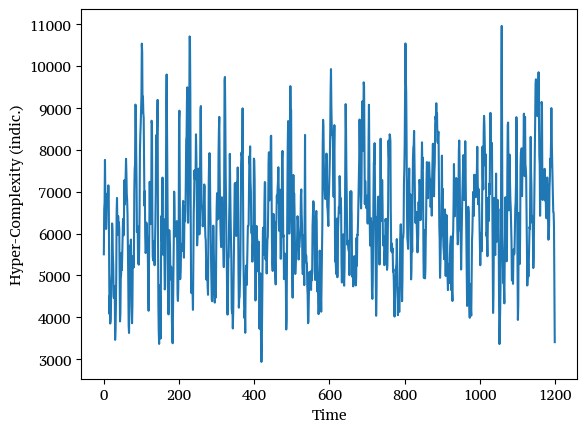

In [29]:
plt.plot(timepoints, hyper_complexity)
plt.xlabel("Time")
plt.ylabel("Hyper-Complexity (indic.)")
plt.show()

### Edges projection file

- Opening the h5py file, we've found different datasets
- Each dataset correspond to a timepoint

In [30]:
def print_first_n_datasets(h5_path, n=10):
    with h5py.File(h5_path, "r") as f:
        count = 0
        print(f"\nTotal dataset: {len(f.keys())}", "\n")
        print(f"Here {n} dataset:")
        for name in f:
            obj = f[name]
            if isinstance(obj, h5py.Dataset):
                print(f"[DATASET] {name} → shape: {obj.shape}, dtype: {obj.dtype}")
                count += 1
                if count >= n:
                    break

print_first_n_datasets(sub1_output_proj, n=10)


Total dataset: 1200 

Here 10 dataset:
[DATASET] 0 → shape: (3487, 4), dtype: float32
[DATASET] 1 → shape: (3493, 4), dtype: float32
[DATASET] 10 → shape: (3613, 4), dtype: float32
[DATASET] 100 → shape: (3481, 4), dtype: float32
[DATASET] 1000 → shape: (3501, 4), dtype: float32
[DATASET] 1001 → shape: (3523, 4), dtype: float32
[DATASET] 1002 → shape: (3511, 4), dtype: float32
[DATASET] 1003 → shape: (3537, 4), dtype: float32
[DATASET] 1004 → shape: (3571, 4), dtype: float32
[DATASET] 1005 → shape: (3537, 4), dtype: float32


- **Rows** = Triangles at that point
- **Columns** of the array
    1. node $i$
    2. node $j$
    3. Magnitude edge $w_{ij}$ → la somma dei pesi dei triangoli violanti che includono quell’arco
    4. Times edge $(i,j)$ belongs to triangle $(i,j,\bullet)$ ] → quanti triangoli violanti contengono quell’arco


In [31]:
with h5py.File(sub1_output_proj, "r") as f:
    dataset = f["77"][:]
    print("Shape:", dataset.shape, "\n")
    print("First rows:")
    for row in dataset[:5]:
        i = int(row[0])
        j = int(row[1])
        w_sum = float(row[2])
        count = int(row[3])
        print(f"Edge: ({i}, {j}), weight_sum={w_sum:.4f}, count={count}")


Shape: (3691, 4) 

First rows:
Edge: (19, 20), weight_sum=128.6941, count=62
Edge: (19, 98), weight_sum=130.4026, count=69
Edge: (20, 98), weight_sum=167.4754, count=71
Edge: (16, 20), weight_sum=122.2417, count=68
Edge: (16, 98), weight_sum=132.8439, count=67


Here below a dataset. So we selected a specific time point and we look at the rows inside (=triangles)

In [32]:
edge_files_sub1=h5py.File(sub1_output_proj)

In [33]:
edge_files_sub1['77'][:]

array([[1.9000000e+01, 2.0000000e+01, 1.2869406e+02, 6.2000000e+01],
       [1.9000000e+01, 9.8000000e+01, 1.3040259e+02, 6.9000000e+01],
       [2.0000000e+01, 9.8000000e+01, 1.6747539e+02, 7.1000000e+01],
       ...,
       [3.8000000e+01, 1.1600000e+02, 1.1333670e-01, 3.0000000e+00],
       [8.2000000e+01, 1.1600000e+02, 4.1146923e-02, 1.0000000e+00],
       [5.0000000e+00, 1.0600000e+02, 3.4269512e-02, 1.0000000e+00]],
      dtype=float32)

In [34]:
edge_files_sub1.close()

### Homological Scaffold file

Open a generator file and check inside

In [35]:
sys.path.append(path_scaffold_folder)  # add parent directory to import the module Holes
import Holes as ho
import networkx as nx

In [36]:
# Carica il dizionario = generatore topologico 0
with open(generators0, "rb") as f:
    generator_dict = pk.load(f)

# Stampa le dimensioni omologiche presenti (es: 1, 2, ...)
print("Omology groups presenti:", list(generator_dict.keys()))

# Esplora H1 (cicli di 1° ordine)
cycles_H1 = generator_dict[1]  # oppure cambia il numero per H2, ecc
print(f"\nNumero di cicli H1:", len(cycles_H1))

# Stampa i primi 3 cicli
for i, cycle in enumerate(cycles_H1[:3]):
    print(f"\nCiclo {i+1}")
    print("  Persistenza:", cycle.persistence_interval())
    print("  Archi:", cycle.cycles())
    print("  Nodi:", cycle.cycle_nodes())


Omology groups presenti: [1]

Numero di cicli H1: 6903

Ciclo 1
  Persistenza: 0.12934851338171294
  Archi: [['49', '51'], ['51', '117'], ['49', '117']]
  Nodi: ['51', '117', '49']

Ciclo 2
  Persistenza: 0.13362065606944418
  Archi: [['76', '78'], ['78', '117'], ['76', '117']]
  Nodi: ['117', '76', '78']

Ciclo 3
  Persistenza: 0.22459316499541404
  Archi: [['49', '75'], ['62', '75'], ['49', '62']]
  Nodi: ['75', '62', '49']


Here the code to build a scaffold.

Check the documentaion of networkx

In [1]:
def load_scaffold_singletime(filepath_scaffold, single_time, ScafH=None, hom_group=1):
    """
    Costruisce lo homological scaffold (H1) per un singolo time point.    """
    if ScafH is None:
        # Empty graph
        ScafH = nx.Graph()

    # File with generators
    path = os.path.join(filepath_scaffold, f'generators__{single_time}.pck')
    with open(path, 'rb') as f:
        gen = pk.load(f)

    # Loop on the generators of the selected homology group
    for c in gen[hom_group]:  # H1
        # Persistence is a scalar
        w = float(c.persistence_interval())

        # For each edge in the cycle, add π_g
        for e in c.cycles():
            u, v = int(e[0]), int(e[1])
            if ScafH.has_edge(u, v):
                # Add weight with subscript notation (Edge attributes)
                ScafH[u][v]['weight'] += w
            else:
                ScafH.add_edge(u, v, weight=w)

    return ScafH


In [37]:
ScafH = load_scaffold_singletime(
    sub1_scaffold3 ,
    single_time='0',
    hom_group=1
)

Plot the homological scaffold

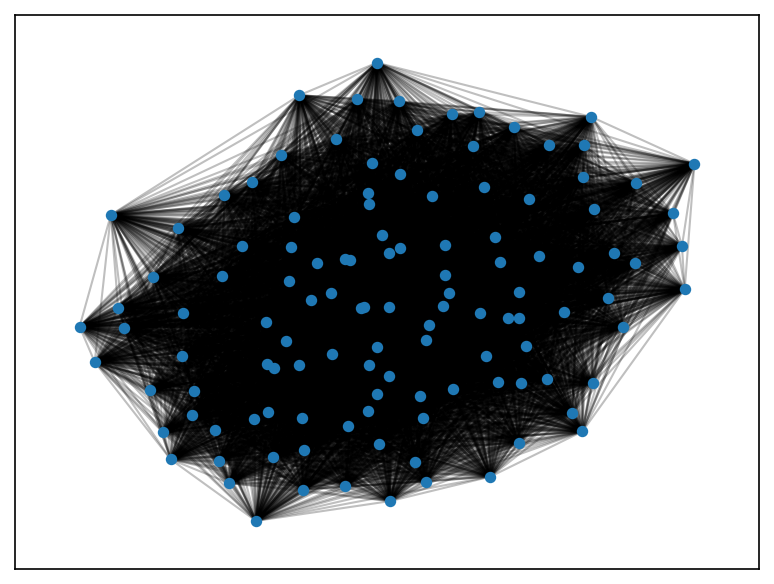

In [38]:
plt.figure(dpi=150)
layout = nx.drawing.layout.spring_layout(ScafH)
nx.draw_networkx_edges(ScafH, pos=layout,alpha=0.25)
nx.draw_networkx_nodes(ScafH, pos=layout,node_size=20)

## Plotting the nodal strength

In [43]:
num_ROIs = 119
cmap = mcolors.LinearSegmentedColormap.from_list(
    "green_yellow_red",
    ["#2ca25f", "#ffffbf", "#d73027"])

### Violating triangles

Codice per computare la nodal strenght (vedi notion)

In [22]:
def compute_nodal_strength(triangle_data, num_ROIs=100):
    edge_weights = {}

    # Per ogni triangolo violante
    for row in triangle_data:
        # i due vertici che definiscono l’arco
        i, j = int(row[0]), int(row[1])
        # la somma dei pesi dei triangoli (i,j,k) che includono quell’arco
        sum_w = row[2]
        # quanti triangoli includono quell’arco
        count = row[3]
        # considera lo stesso arco (i,j) = (j,i)
        edge = tuple(sorted((i, j)))
        if count > 0:
            # media dei pesi dei triangoli che contengono (i,j)
            w_ij = sum_w / count
            # aggiungo l'arco al dizionario (ridondante)
            if edge not in edge_weights:
                edge_weights[edge] = w_ij

    nodal_strength = np.zeros(num_ROIs)


    for (i, j), w_ij in edge_weights.items():
        if i < num_ROIs:
            nodal_strength[i] += w_ij
        if j < num_ROIs:
            nodal_strength[j] += w_ij

    return nodal_strength

Qui plotto un solo fame, quindi un solo istante
 temporale

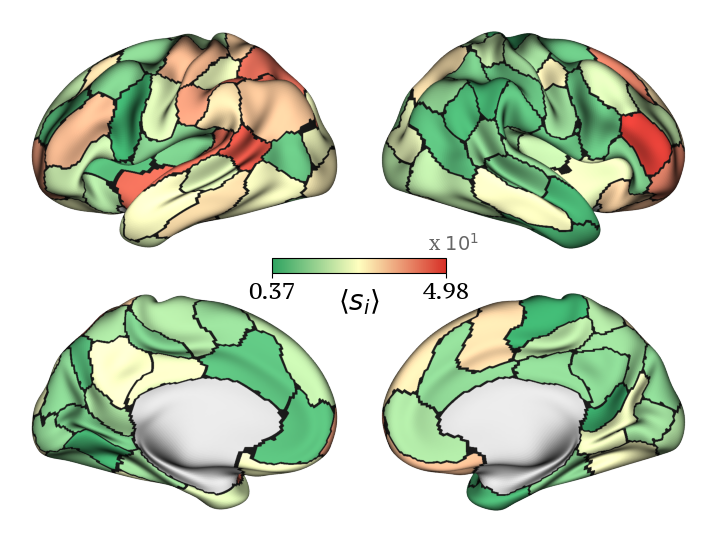

In [23]:
with h5py.File(sub1_output_proj, "r") as f:
    triangle_data = f["0"][:]  # Frame 0
    nodal_strength_single = compute_nodal_strength(triangle_data, num_ROIs=100)

fig = normal_view(
    current_nodestrength=nodal_strength_single,
    edges=True,
    cmap = cmap,
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)

Qui plotto tutti gli istanti temporali del mio file, concatenandoli

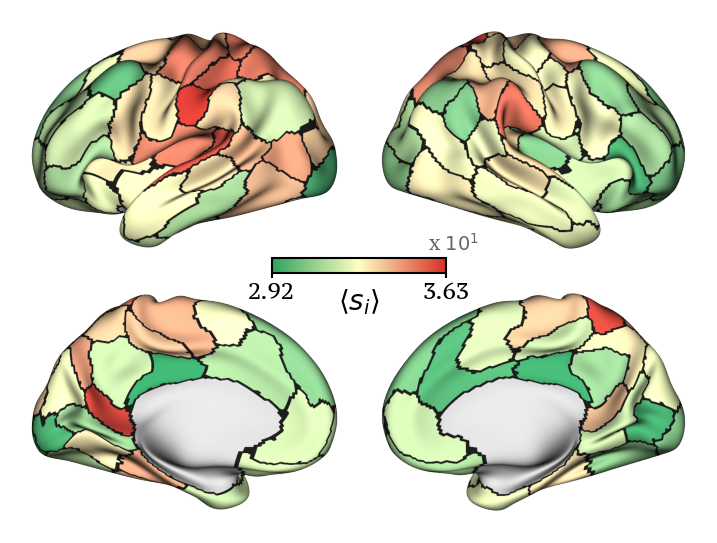

In [24]:
all_nodal_strengths = []

with h5py.File(sub1_output_proj, "r") as f:
    for key in f.keys():
        triangle_data = f[key][:]
        nodal_strength = compute_nodal_strength(triangle_data, num_ROIs=100)
        all_nodal_strengths.append(nodal_strength)

mean_nodal_strength = np.mean(np.stack(all_nodal_strengths), axis=0)

fig = normal_view(
    current_nodestrength=mean_nodal_strength,
    edges=True,
    cmap=cmap,    #RdBu_r
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)

Plotta i 15 frames temporali più coerenti

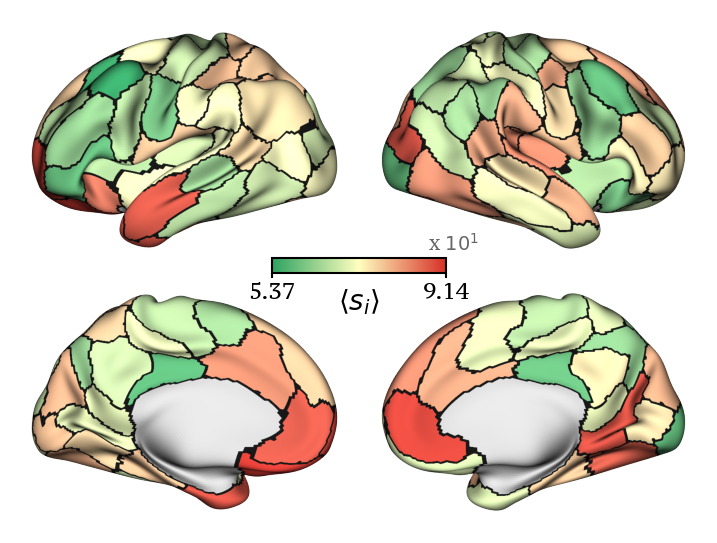

In [25]:
# Load results and select top 15% timepoints by hyper-coherence
results = np.loadtxt(sub1_output_sorted)
timepoints = results[:, 0].astype(int)
hyper_coherence = results[:, 5]

n_top = int(np.ceil(len(timepoints) * 0.15))
top_indices = np.argsort(hyper_coherence)[-n_top:]
top_timepoints = timepoints[top_indices]

top_nodal_strengths = []

with h5py.File(sub1_output_proj, "r") as f:
    for t in top_timepoints:
        triangle_data = f[str(t)][:]
        nodal_strength = compute_nodal_strength(triangle_data, num_ROIs=100)
        top_nodal_strengths.append(nodal_strength)

mean_top_nodal_strength = np.mean(np.stack(top_nodal_strengths), axis=0)

fig = normal_view(
    current_nodestrength=mean_top_nodal_strength,
    edges=True,
    cmap=cmap,
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)


### Homological scaffold

'weight' = name of an edge attribute that holds the numerical value used as a weight

In [39]:
ScafH_0 = load_scaffold_singletime(sub1_scaffold3, single_time=0)
ScafH_0.degree(weight='weight')

DegreeView({49: 261.7770845666739, 51: 277.5216206785377, 117: 720.8854323438967, 76: 429.13040212842037, 78: 341.86285019233634, 75: 121.2206077141098, 62: 628.4103389893814, 9: 970.6147860928949, 85: 375.69356052553434, 39: 1693.0451595356797, 7: 592.8566642419381, 33: 654.874978414079, 44: 262.33784251795913, 97: 394.94915222699143, 17: 2578.886837281708, 56: 830.7443693754816, 3: 152.90905408898126, 16: 806.076652375536, 40: 598.9431488038533, 105: 7567.1408408652, 55: 168.36821099265512, 24: 1031.1339704242666, 82: 575.473976878996, 106: 1417.1198526799835, 93: 309.1534094482505, 32: 110.50432714526613, 34: 187.07440951623397, 96: 334.8311199207617, 47: 185.93045416494414, 90: 144.84148437214162, 69: 658.233497525896, 52: 131.09841872588115, 38: 141.7248360633213, 20: 194.7220324319072, 30: 142.39199802461258, 42: 135.51141691350446, 23: 188.77851922312468, 15: 189.08563579907124, 12: 165.24306449737554, 64: 137.22307006889181, 45: 161.09776040903444, 59: 119.91479703432283, 13: 8

Per computare la forza nodale

In [44]:
def compute_nodal_strength_scaffold(ScafH, num_ROIs=100):
    # Nodal strength: somma dei pesi degli archi incidenti a ciascun nodo
    nodal_strength = np.zeros(num_ROIs)
    for node, strength in ScafH.degree(weight='weight'):
        # We are maintaining only nodes that are below the number of ROI
        if isinstance(node, int) and node < num_ROIs:
            nodal_strength[node] = strength
    return nodal_strength


Plot per singolo frame

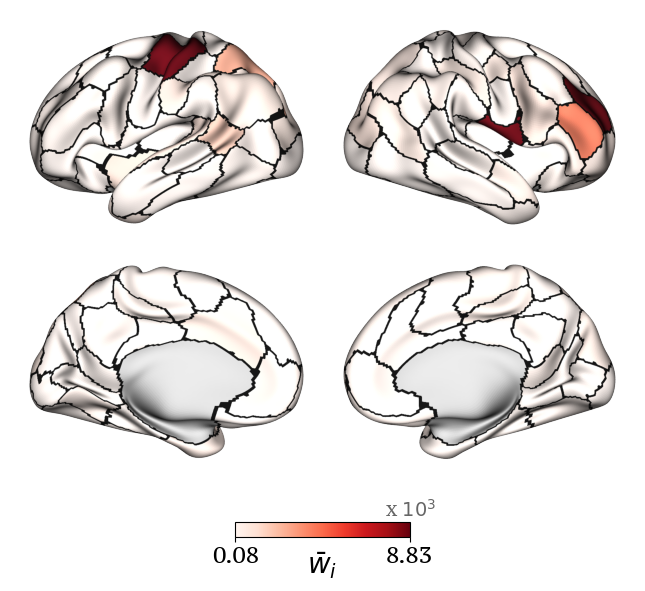

In [45]:
# Scaffold generation
ScafH_0 = load_scaffold_singletime(sub1_scaffold3, single_time=0)

# Node strength
nodal_strength_0 = compute_nodal_strength_scaffold(ScafH_0, num_ROIs=num_ROIs)

fig = normal_view( current_nodestrength=nodal_strength_0, edges=True, cmap='Reds', q_thresh=0.0, center_cbar=False, alpha_graymap=0.99, xlabel=r"$\bar{w}_i$" )

Tutti i frame

Found 1173 frames.


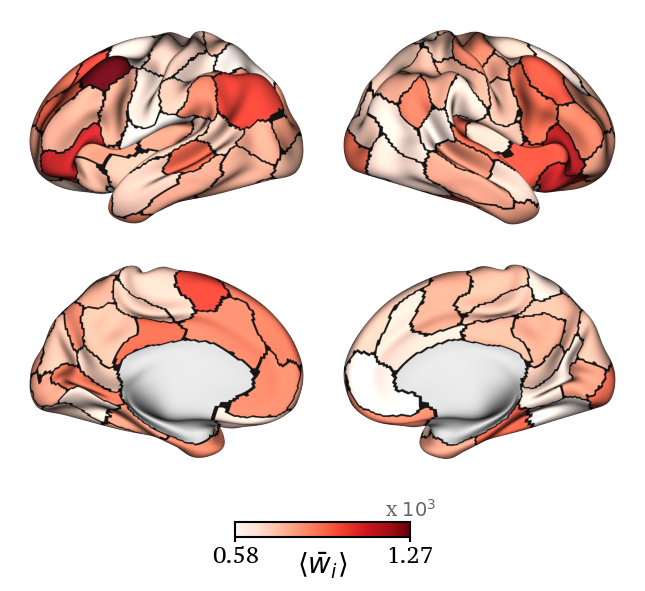

In [47]:
# Directory con i .pck
pck_paths = sorted(glob.glob(os.path.join(sub1_scaffold3, "generators__*.pck")))
print(f"Found {len(pck_paths)} frames.")

all_strengths = []

for path in pck_paths:
    # 1) estrai il time point dal nome file
    m = re.search(r"generators__(\d+)\.pck$", os.path.basename(path))
    if not m:
        continue
    t = int(m.group(1))

    # 2) costruisci lo scaffold di quel frame
    ScafH_t = load_scaffold_singletime(sub1_scaffold3, single_time=t)

    # 3) nodal strength dal grafo
    nodal_strength_t = compute_nodal_strength_scaffold(ScafH_t, num_ROIs=num_ROIs)

    all_strengths.append(nodal_strength_t)

# Media sui frame
mean_all = np.mean(np.stack(all_strengths, axis=0), axis=0)

# Visualizzazione
fig = normal_view(
    current_nodestrength=mean_all,
    edges=True,
    cmap="Reds",
    q_thresh=0.0,
    center_cbar=False,
    alpha_graymap=0.99,
    xlabel=r"$\langle \bar{w}_i \rangle$"
)

15 frame a minore hyper-complexity

In [48]:
results = np.loadtxt(sub1_output_sorted)
timepoints = results[:, 0].astype(int)
complexity = results[:, 1]

n_top = int(np.ceil(len(timepoints) * 0.15))
top_timepoints = timepoints[np.argsort(complexity)[:n_top]]
#print(top_timepoints)


In [49]:
count = 0
for n in top_timepoints:
    if n not in missing3:
        count +=1
    else:
        print(f"{n} is missing")
print (f"\nFound {count} frames.")
print(f"Total top timepoints: {len(top_timepoints)}")


Found 180 frames.
Total top timepoints: 180


 ...done. (4 seconds, 0 min)
Extracting data from /home/sun/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz..... done.


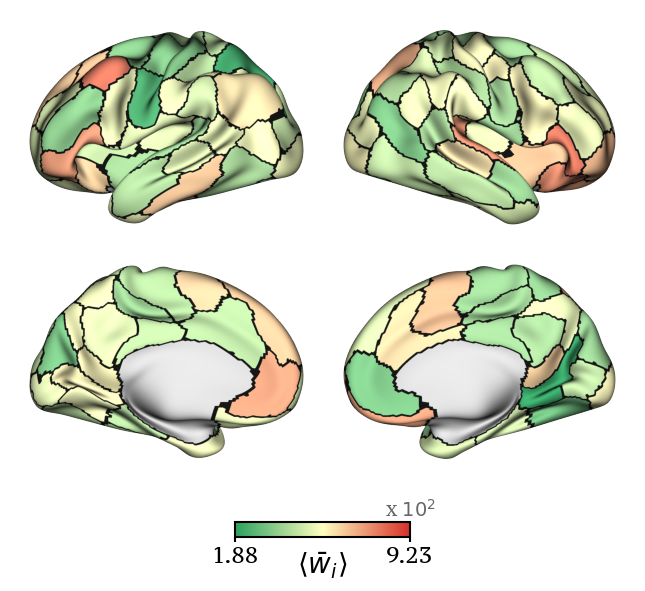

In [52]:
strengths_top = []
for t in top_timepoints:
    path = os.path.join(sub1_scaffold, f"generators__{t}.pck")
    if not os.path.exists(path):
        print(f"File mancante per time point {t}, salto...")
        continue

    # 1) costruisci lo scaffold del frame t
    ScafH_t = load_scaffold_singletime(sub1_scaffold, single_time=t)

    # 2) calcola la nodal strength dallo scaffold
    nodal_strength_t = compute_nodal_strength_scaffold(ScafH_t, num_ROIs=num_ROIs)

    strengths_top.append(nodal_strength_t)

if strengths_top:
    mean_top = np.mean(np.stack(strengths_top, axis=0), axis=0)

    fig = normal_view(
        current_nodestrength=mean_top,
        edges=True,
        cmap=cmap,
        q_thresh=0.0,
        center_cbar=False,
        alpha_graymap=0.99,
        xlabel=r"$\langle \bar{w}_i \rangle$"
    )
else:
    print("Nessun time point valido trovato.")


## Triangular representation

In [32]:
data = np.loadtxt(sub1_output_sorted)

# Extract FC, CT, FD contributions and sum up them
FC = data[:, 2]
CT = data[:, 3]
FD = data[:, 4]
total = FC + CT + FD

# Normalize
fc_norm = FC / total
ct_norm = CT / total
fd_norm = FD / total

# To map coordintes in a triangle
x = 0.5 * (2 * fd_norm + ct_norm)
y = (np.sqrt(3) / 2) * ct_norm

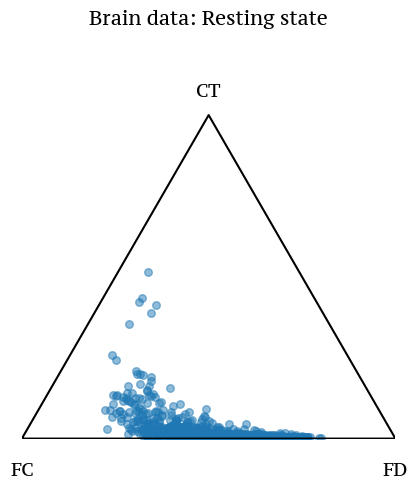

In [33]:
fig, ax = plt.subplots(figsize=(5.5, 5))

triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])
ax.plot(triangle[:, 0], triangle[:, 1], color='black', lw=1.5)

ax.scatter(x, y, color="#1f78b4", alpha=0.5, s=30)

ax.text(0, -0.06, "FC", ha='center', va='top', fontsize=13)
ax.text(1, -0.06, "FD", ha='center', va='top', fontsize=13)
ax.text(0.5, np.sqrt(3)/2 + 0.04, "CT", ha='center', va='bottom', fontsize=13)
ax.set_title("Brain data: Resting state", fontsize=14, pad=25)
ax.set_xlim(0, 1)
ax.set_ylim(0, np.sqrt(3)/2 + 0.15)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()
